# Assignment 1B

# Import Functions

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# numpy handles pretty much anything that is a number/vector/matrix/array
import numpy as np
# pandas handles dataframes
import pandas as pd
# matplotlib emulates Matlabs plotting functionality
import matplotlib.pyplot as plt
# seaborn is another good plotting library. In particular, I like it for heatmaps (https://seaborn.pydata.org/generated/seaborn.heatmap.html)
import seaborn as sns;
# stats models is a package that is going to perform the regression analysis
from statsmodels import api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
# os allows us to manipulate variables on out local machine, such as paths and environment variables
import os
# self explainatory, dates and times
from datetime import datetime, date
# a helper package to help us iterate over objects
import itertools

import time


## Q1
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.spatial import distance
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram
from matplotlib import cm

## Q2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist

from tensorflow.keras import regularizers

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import model_to_dot, plot_model

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.svm import SVC, NuSVC
from tensorflow.keras.callbacks import ModelCheckpoint


# To export as pdf with better quality plots
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')


Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Problem 1. Clustering and Recommendations.

Using the provided data, and (optionally) the above described code you are
to develop a method to cluster users based on their movie viewing preferences. Having
developed this, provide recommendations for the users with the IDs 4, 42, and 314.

A suggested approach to solving this problem is to:
*    Cluster the combined table that contains the average rating each user has reported for
movies belonging to each genre. You will have to decide how you treat genres that
have an average rating of NaN, which indicates that the user has not watched any
movies from this genre; and select an appropriate clustering method and clustering
hyper-parameters.


*   Identify the clusters that contain the target users, 4, 42, and 314.
*    Find the most popular movies within clusters that contain the target users, that the
target users have not already seen.

Note that the above is simply a suggested approach, and you are welcome to select an alter-
nate method.

In [ ]:
## Utils

#
# Utility functions for CAB420, Assignment 1C, Q1
# Author: Simon Denman (s.denman@qut.edu.au)
#

import pandas   # to load csvs and manipulate the resulting data frames
import math     # for isnan
import os       # for path stuff

# load the data, in particular the movies and ratings files
#   base_path: directory that contains the quetions CSV files
#
#   returns:   dataframes for movies.csv and ratings.csv
#
def load_data(base_path):
    # simply using pandas.read_csv here
    movies = pandas.read_csv(os.path.join(base_path, 'movies.csv'))
    ratings = pandas.read_csv(os.path.join(base_path, 'ratings.csv'))
    return movies, ratings

# get a modified version of the ratings table, that has the average rating fo each film
#   ratings_table: data frame for the movies ratings
#
#   returns:       dataframe that contains movie IDs and the average ratings for each movie
#
def get_average_rating_per_film(ratings_table):
    # drop userId and timestamp as the average of these is meaningless
    # group the data by the movieId, and average the remaining columns (rating)
    return ratings_table.drop(columns=['userId', 'timestamp']).groupby('movieId').mean()

# replace the 'genre' column with a series of columns, one per genre, where a value of 1
# indicates that the genre is presnet in the movie. Any genre not present will be set
# to NaN
#   movies_table: dataframe for the movies
#
#   returns:      modified dataframe, where the genre column has been expanded to have one column for each genre, and the
#                 set of genres
#
def expand_genres(movies_table):

    # copy the table to create a working copy
    movies = movies_table.copy()
    # build a set of all the different genres, start with an empty set
    genres = set()
    # loop through all the movies
    for i, row in movies.iterrows():
        # build a set of genres for each movie, and get the union of this and the overall genre set
        genres = genres.union(set(row['genres'].split('|')))

    # create a column for each of our new genres
    for g in genres:
        movies[g] = float("Nan")

    # loop through the movies
    for i, row in movies.iterrows():
        # and the genres present in each movie
        for g in set(row['genres'].split('|')):
            # and where a genre is present in a movie, set it to 1
            movies.loc[i,g] = 1

    # drop the original genres column
    movies = movies.drop(columns=['genres'])

    # return expanded table
    return movies, genres

# build a table that has the details of all movies a user has seen. This will essentially replace the movieID with
# the genre flags for a film, and change the 1.0's that indicate what genre a movie is to the user rating for the film.
# This representation is primarily intended as an intermediate step to getting an average rating per user across
# genres, but you may use this (or vary it to get other aggregrated data) if you so choose.
#   ratings_table: dataframe of ratings
#   movies_table:  dataframe of movies, expanded to have individual columns for each genres
#   genres:        set of genres
#
#   returns:       merged dataframe, consisting of user IDs and the genres of all movies they've watched and the rating
#
def movies_per_user(ratings_table, movies_table, genres):
    # merge of movieId
    merged = pandas.merge(ratings_table, movies_table, how='left', on="movieId")
    # loop across the merged table
    for i, row in merged.iterrows():
        # and the set of genres
        for g in genres:
            # and for any genre that is set for a movie
            if not math.isnan(row[g]):
                # set it's value to the rating the user gave the movie
                merged.loc[i, g] = row["rating"]

    # drop the movieId, rating, timestamp, and title columns
    merged_all_movies = merged.drop(columns=['movieId', 'rating', 'timestamp', 'title'])

    # return merged table
    return merged_all_movies

# get the average rating per genre for each user
#   movies_per_user_table: dataframe, that's the output of movies_per_user()
#
#   returns:               dataframe with one row per user, which contains the average rating given to movies of each
#                          genre. Genres that the user has never seen will have a value of NaN
#
def average_per_user(movies_per_user_table):
    return movies_per_user_table.groupby(['userId']).mean()


In [ ]:
# Load the data
movies, ratings = load_data('/content/drive/My Drive/Assignment 1C/CAB420_Assessment_1C_Data/Q1/')
print(movies.shape)
print(ratings.shape)
print(movies.head())
print(ratings.head())

(9742, 3)
(100836, 4)
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931




---



## From Utils Demo

### Average Rating Per Film
Note that the output is now 9,724 rows, which suggests that 18 movies in the database have not been watched by anyone.

In [ ]:
average_rating_per_film = get_average_rating_per_film(ratings)
print(average_rating_per_film.shape)
average_rating_per_film.head()

(9724, 1)


,rating
movieId,
1,3.920930
2,3.431818
3,3.259615
4,2.357143
5,3.071429


### Pulling Our Genres

In [ ]:
movies_with_genres, genres = expand_genres(movies)
print(movies_with_genres.shape)
movies_with_genres.head()

(9742, 22)


,movieId,title,Western,Children,Thriller,Action,Crime,Fantasy,Comedy,Romance,...,Musical,(no genres listed),IMAX,Documentary,War,Film-Noir,Adventure,Drama,Horror,Sci-Fi
0,1,Toy Story (1995),NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1,2,Jumanji (1995),NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2,3,Grumpier Old Men (1995),NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Waiting to Exhale (1995),NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
4,5,Father of the Bride Part II (1995),NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Detailed Data For Users

Users movie ratings for what they've seen

In [ ]:
user_movies = movies_per_user(ratings, movies_with_genres, genres)
print(user_movies.shape)
user_movies.head()

(100836, 21)


,userId,Western,Children,Thriller,Action,Crime,Fantasy,Comedy,Romance,Mystery,...,Musical,(no genres listed),IMAX,Documentary,War,Film-Noir,Adventure,Drama,Horror,Sci-Fi
0,1,NaN,4.0,NaN,NaN,NaN,4.0,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,NaN,NaN,4.0,4.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,NaN,NaN,5.0,NaN,5.0,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Group user movie ratings by user ID

In [ ]:
user_genre_ratings = average_per_user(user_movies)
print(user_genre_ratings.shape)
user_genre_ratings.head()

(610, 20)


,Western,Children,Thriller,Action,Crime,Fantasy,Comedy,Romance,Mystery,Animation,Musical,(no genres listed),IMAX,Documentary,War,Film-Noir,Adventure,Drama,Horror,Sci-Fi
userId,,,,,,,,,,,,,,,,,,,,
1,4.285714,4.547619,4.145455,4.322222,4.355556,4.297872,4.277108,4.307692,4.166667,4.689655,4.681818,NaN,NaN,NaN,4.500000,5.0,4.388235,4.529412,3.470588,4.225000
2,3.500000,NaN,3.700000,3.954545,3.800000,NaN,4.000000,4.500000,4.000000,NaN,NaN,NaN,3.750000,4.333333,4.500000,NaN,4.166667,3.882353,3.000000,3.875000
3,NaN,0.500000,4.142857,3.571429,0.500000,3.375000,1.000000,0.500000,5.000000,0.500000,0.500000,NaN,NaN,NaN,0.500000,NaN,2.727273,0.750000,4.687500,4.200000
4,3.800000,3.800000,3.552632,3.320000,3.814815,3.684211,3.509615,3.379310,3.478261,4.000000,4.000000,NaN,3.000000,4.000000,3.571429,4.0,3.655172,3.483333,4.250000,2.833333
5,3.000000,4.111111,3.555556,3.111111,3.833333,4.142857,3.466667,3.090909,4.000000,4.333333,4.400000,NaN,3.666667,NaN,3.333333,NaN,3.250000,3.800000,3.000000,2.500000


This is one suggested dataset to cluster, which would allow you to characterise a users taste in films, much like the practical question looked at the trip advisor data.

***Q. With Q1, if we use genres as suggested above, what do we do if a user has never seen a film from a particular genre?***

A. You could replace this value with the average, set it to the minimum (assume that having never seen a genre is an indication that they are not a fan), or come up with a distance metric that allows you to compare in spite of the missing data. Note that the last option is a bit tricky (but cool and interesting), and if you're not confident don't go there.

In [ ]:
## Replace all NaN values with the minimum
#Now, we can replace them
user_genre_ratings_use = user_genre_ratings.fillna(0)
user_genre_ratings_use

,Western,Children,Thriller,Action,Crime,Fantasy,Comedy,Romance,Mystery,Animation,Musical,(no genres listed),IMAX,Documentary,War,Film-Noir,Adventure,Drama,Horror,Sci-Fi
userId,,,,,,,,,,,,,,,,,,,,
1,4.285714,4.547619,4.145455,4.322222,4.355556,4.297872,4.277108,4.307692,4.166667,4.689655,4.681818,0.0,0.000000,0.000000,4.500000,5.0000,4.388235,4.529412,3.470588,4.225000
2,3.500000,0.000000,3.700000,3.954545,3.800000,0.000000,4.000000,4.500000,4.000000,0.000000,0.000000,0.0,3.750000,4.333333,4.500000,0.0000,4.166667,3.882353,3.000000,3.875000
3,0.000000,0.500000,4.142857,3.571429,0.500000,3.375000,1.000000,0.500000,5.000000,0.500000,0.500000,0.0,0.000000,0.000000,0.500000,0.0000,2.727273,0.750000,4.687500,4.200000
4,3.800000,3.800000,3.552632,3.320000,3.814815,3.684211,3.509615,3.379310,3.478261,4.000000,4.000000,0.0,3.000000,4.000000,3.571429,4.0000,3.655172,3.483333,4.250000,2.833333
5,3.000000,4.111111,3.555556,3.111111,3.833333,4.142857,3.466667,3.090909,4.000000,4.333333,4.400000,0.0,3.666667,0.000000,3.333333,0.0000,3.250000,3.800000,3.000000,2.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,3.411765,3.448980,3.525126,3.178808,3.654135,3.597938,3.565321,3.740845,3.791209,3.714286,3.727273,0.0,3.062500,3.800000,3.792308,3.8125,3.503401,3.787966,3.346154,3.556962
607,4.000000,3.421053,4.114754,3.722222,3.814815,3.571429,3.327273,3.517241,4.647059,3.333333,3.600000,0.0,5.000000,0.000000,4.166667,0.0000,3.466667,4.012195,4.114286,3.250000
608,2.636364,2.460227,3.536680,3.330325,3.613014,3.000000,2.736620,2.886792,3.550725,3.118182,2.757576,0.0,4.000000,3.000000,3.578947,3.7500,3.220994,3.437500,3.319588,3.296407


## Plot the Target User's Ratings

        Western  Children  Thriller  Action     Crime   Fantasy    Comedy  \
userId                                                                      
4           3.8       3.8  3.552632    3.32  3.814815  3.684211  3.509615   

        Romance   Mystery  Animation  Musical  (no genres listed)  IMAX  \
userId                                                                    
4       3.37931  3.478261        4.0      4.0                 0.0   3.0   

        Documentary       War  Film-Noir  Adventure     Drama  Horror  \
userId                                                                  
4               4.0  3.571429        4.0   3.655172  3.483333    4.25   

          Sci-Fi  
userId            
4       2.833333  


Text(0.5, 1.0, 'User 4')

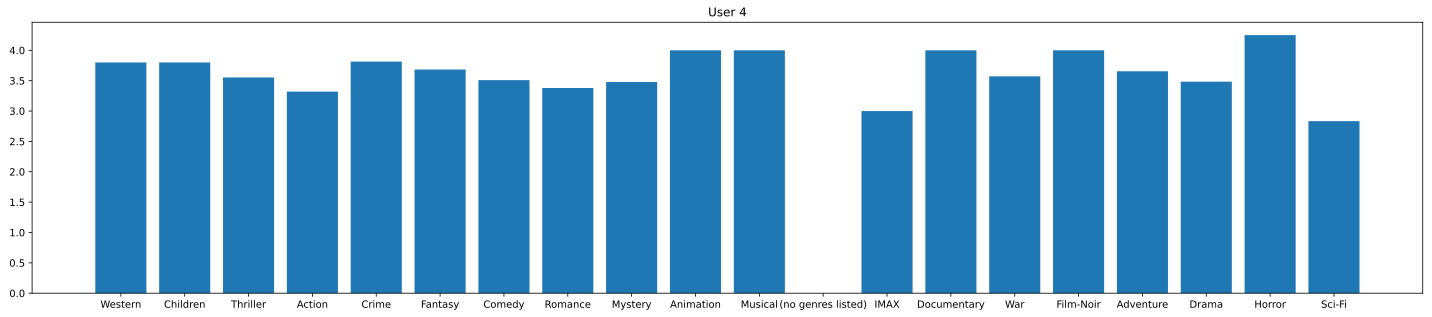

In [ ]:
## User 4
user4_data = user_genre_ratings_use.iloc[3]
print(user_genre_ratings_use.iloc[3:4])
x = ['Western', 	'Children', 	'Thriller', 	'Action', 	'Crime', 	'Fantasy', 	'Comedy', 	'Romance', 	'Mystery', 	'Animation', 	'Musical', '(no genres listed)',
          	'IMAX', 	'Documentary', 	'War', 	'Film-Noir', 	'Adventure', 	'Drama', 	'Horror', 	'Sci-Fi']


fig = plt.figure(figsize=[25, 5])
ax = fig.add_subplot(1, 1, 1)
ax.bar(x, user4_data)
ax.set_title('User 4')

         Western  Children  Thriller  Action     Crime   Fantasy    Comedy  \
userId                                                                       
42      3.916667  2.928571  3.577586     3.4  3.746479  3.590909  3.412322   

         Romance   Mystery  Animation   Musical  (no genres listed)  IMAX  \
userId                                                                      
42      3.640449  3.962963        4.0  3.857143                 0.0   4.5   

        Documentary       War  Film-Noir  Adventure     Drama  Horror  Sci-Fi  
userId                                                                         
42         4.333333  3.809524        3.5   3.513889  3.818713     3.0    3.25  


Text(0.5, 1.0, 'User 42')

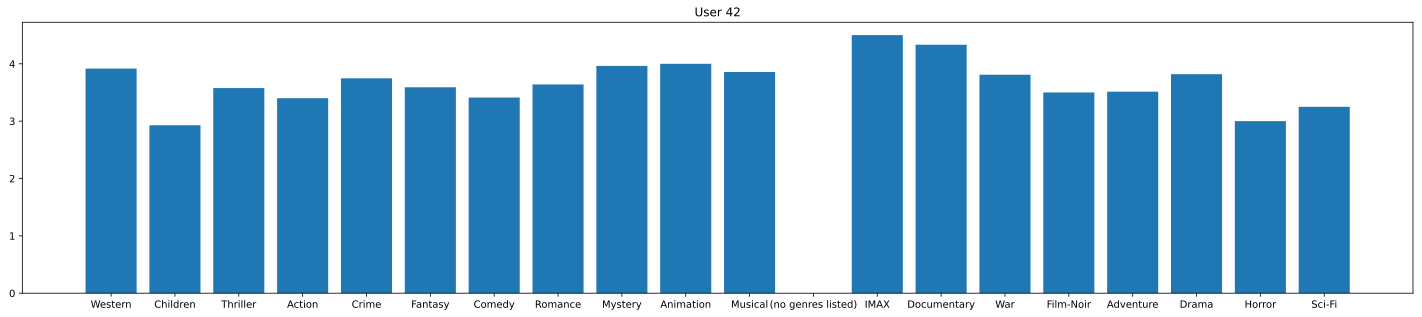

In [ ]:
## User 42
user42_data = user_genre_ratings_use.iloc[41]
print(user_genre_ratings_use.iloc[41:42])
x = ['Western', 	'Children', 	'Thriller', 	'Action', 	'Crime', 	'Fantasy', 	'Comedy', 	'Romance', 	'Mystery', 	'Animation', 	'Musical', '(no genres listed)',
          	'IMAX', 	'Documentary', 	'War', 	'Film-Noir', 	'Adventure', 	'Drama', 	'Horror', 	'Sci-Fi']
fig = plt.figure(figsize=[25, 5])
ax = fig.add_subplot(1, 1, 1)
ax.bar(x, user42_data)
ax.set_title('User 42')

        Western  Children  Thriller  Action  Crime   Fantasy  Comedy  \
userId                                                                 
314         2.6  3.153846  2.710526    2.82    3.0  3.214286  3.0625   

         Romance  Mystery  Animation   Musical  (no genres listed)      IMAX  \
userId                                                                         
314     3.357143      3.0      3.125  3.166667                 0.0  3.666667   

        Documentary       War  Film-Noir  Adventure  Drama    Horror    Sci-Fi  
userId                                                                          
314             0.0  3.714286        0.0   2.842105    3.4  2.833333  2.961538  


Text(0.5, 1.0, 'User 314')

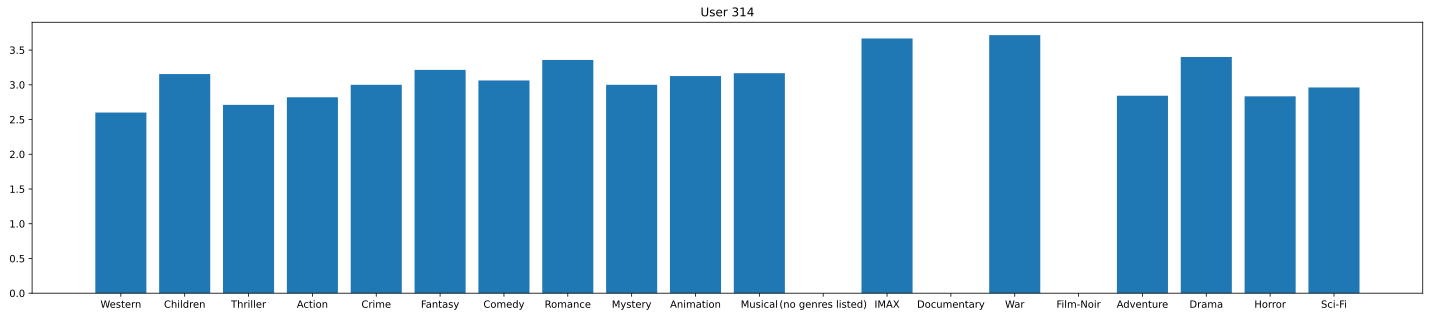

In [ ]:
## User 314
user4_data = user_genre_ratings_use.iloc[313]
print(user_genre_ratings_use.iloc[313:314])
x = ['Western', 	'Children', 	'Thriller', 	'Action', 	'Crime', 	'Fantasy', 	'Comedy', 	'Romance', 	'Mystery', 	'Animation', 	'Musical', '(no genres listed)',
          	'IMAX', 	'Documentary', 	'War', 	'Film-Noir', 	'Adventure', 	'Drama', 	'Horror', 	'Sci-Fi']
fig = plt.figure(figsize=[25, 5])
ax = fig.add_subplot(1, 1, 1)
ax.bar(x, user4_data)
ax.set_title('User 314')

In [ ]:
user_genre_ratings_use.iloc[3]

Western               3.800000
Children              3.800000
Thriller              3.552632
Action                3.320000
Crime                 3.814815
Fantasy               3.684211
Comedy                3.509615
Romance               3.379310
Mystery               3.478261
Animation             4.000000
Musical               4.000000
(no genres listed)    0.000000
IMAX                  3.000000
Documentary           4.000000
War                   3.571429
Film-Noir             4.000000
Adventure             3.655172
Drama                 3.483333
Horror                4.250000
Sci-Fi                2.833333
Name: 4, dtype: float64

## Cluster the data based on users AND Identify Clusters of Users 4, 42, 314

***Q. For Q1, what should I cluster?***

A. Consider that our main aim is to **recommend a movie to a user**, thus one approach would be to **cluster users**, and then **for a new user**, **work out which cluster they belong** to and **recommend movies based on what other people** in that cluster enjoyed. For this, you could **use the genres rather than movies** and use a **person's average scores across genres** to characterise them.

The provided code will set the data up for this approach, but are you are free to do something else.




### Using K-Means Method (prac wk8 Q1 solution)
### 1. Find the best K

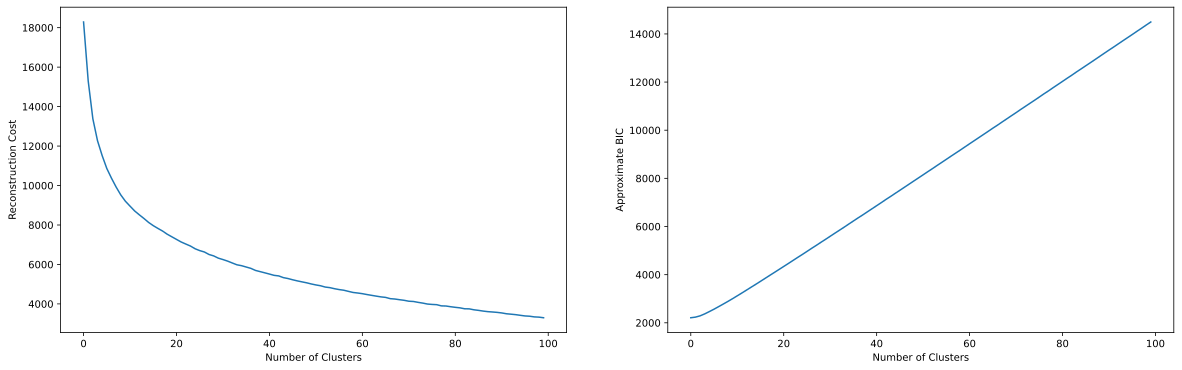

In [ ]:
num_itts = 10

costs = [];
approx_bic = []
for i in range(100):
    c = 0
    a_b = 0
    for r in range(num_itts):
        kmeans = KMeans(n_clusters=i+1, random_state=r).fit(user_genre_ratings_use)

        c += kmeans.inertia_

        k = np.shape(kmeans.cluster_centers_)[0]*(np.shape(kmeans.cluster_centers_)[1] + 1)
        m = len(user_genre_ratings_use)
        a_b += m*np.log(kmeans.inertia_ / m) + k*np.log(m)

    costs.append(c / num_itts)
    approx_bic.append(a_b / num_itts)

fig = plt.figure(figsize=[20, 6])
ax = fig.add_subplot(1, 2, 1)
ax.plot(costs)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Reconstruction Cost');

ax = fig.add_subplot(1, 2, 2)
ax.plot(approx_bic)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Approximate BIC');

In [ ]:
np.argmin(approx_bic) + 1

1

### GMM

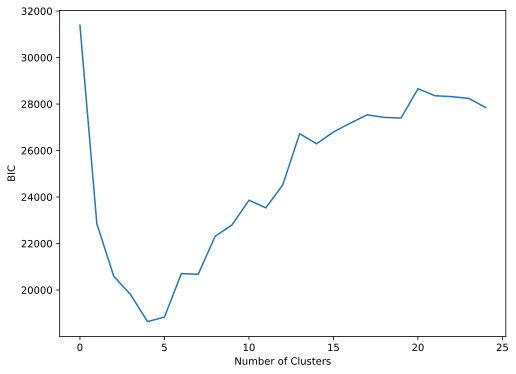

In [ ]:
bics = []
for i in range (25):
    b = 0
    for r in range(num_itts):
        gmm = GaussianMixture(i+1, random_state=r)
        gmm.fit(user_genre_ratings_use)
        b += gmm.bic(user_genre_ratings_use)
    bics.append(b / num_itts)

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(1, 1, 1)
ax.plot(bics)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('BIC');

In [ ]:
np.argmin(bics) + 1

5

### 2 & 3. Visualisation and ...

In [ ]:
def do_kmeans_analysis(n_clusters, random_state, data, abnormal_threshold = 2):

    # train the k-means model
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(data)

    # plot the cluster centres
    x = ['Western', 	'Children', 	'Thriller', 	'Action', 	'Crime', 	'Fantasy', 	'Comedy', 	'Romance', 	'Mystery', 	'Animation', 	'Musical', '(no genres listed)',
          	'IMAX', 	'Documentary', 	'War', 	'Film-Noir', 	'Adventure', 	'Drama', 	'Horror', 	'Sci-Fi']
    fig = plt.figure(figsize=[40, 20])
    for i in range(n_clusters):
        ax = fig.add_subplot(n_clusters, 1, i + 1)
        ax.bar(x, kmeans.cluster_centers_[i,:])
        ax.set_title('Cluster %d' % (i+1))
        print(kmeans.cluster_centers_[i,:])

    # plot the data, we can't plot 10-d data, so we'll run TSNE and show that
    fig = plt.figure(figsize=[20,20])
    ax = fig.add_subplot(1, 1, 1)
    tsne_embeddings = TSNE(random_state=4).fit_transform(np.vstack([data, kmeans.cluster_centers_]))
    ax.scatter(tsne_embeddings[:-n_clusters,0], tsne_embeddings[:-n_clusters,1], c = kmeans.labels_);
    # add cluster centres to the plot
    ax.scatter(tsne_embeddings[-n_clusters:,0], tsne_embeddings[-n_clusters:,1], s=200, marker='x')

    # Identify the clusters that contain the target users, 4, 42, and 314
    # print(kmeans.labels_)

    user_4_cluster = kmeans.labels_[3]
    user_42_cluster = kmeans.labels_[41]
    user_314_cluster = kmeans.labels_[313]

    print(user_4_cluster) # 0
    print(user_42_cluster) # 0
    print(user_314_cluster) # 4

    return kmeans

    # ## Recommend movies
    # user_4_rec =

    # for i in range(n_clusters):
    #     #For cluster 0
    #     if (i == 0):
    #       user_4_notSeen =
    #       user_42_notSeen =
    #     #For cluster 4
    #     elif (i == 4):



    #     ax = fig.add_subplot(n_clusters, 1, i + 1)
    #     ax.bar(x, kmeans.cluster_centers_[i,:])
    #     ax.set_title('Cluster %d' % (i+1))


[3.28281877 3.38257496 3.62745047 3.53010377 3.78031566 3.60178313
 3.57055161 3.62737193 3.75033281 3.55372696 3.4268246  0.29736842
 3.22015288 2.77624584 3.88060486 3.9761641  3.5892752  3.76930725
 3.3804055  3.50873666]
[2.58125220e+00 1.10893923e+00 3.70048851e+00 3.57156526e+00
 3.87928205e+00 2.47303980e+00 3.44605712e+00 3.51899063e+00
 3.50202027e+00 3.16971081e-01 6.75962166e-01 8.32667268e-17
 1.82452707e+00 8.23548598e-01 3.78736996e+00 1.28767123e+00
 3.30800489e+00 3.79819845e+00 2.84420473e+00 3.32830975e+00]
[0.02631579 3.82291808 3.76250525 3.81577737 3.7429276  3.81866381
 3.80627443 3.82052649 3.67709939 3.83450204 2.06680718 0.16315789
 3.85523573 0.51776316 3.57127193 0.21052632 3.89696556 3.90583967
 2.85530065 3.71620338]
[0.8246131  2.8796615  3.18962409 3.07957617 3.19901889 3.12308317
 3.21174735 3.14801366 2.83206795 2.76756847 2.42325124 0.021875
 0.36299388 0.53645833 1.42104902 0.41354167 3.31708167 3.34780528
 2.19099169 3.12825399]
[3.77449254 3.6838581

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


0
0
4


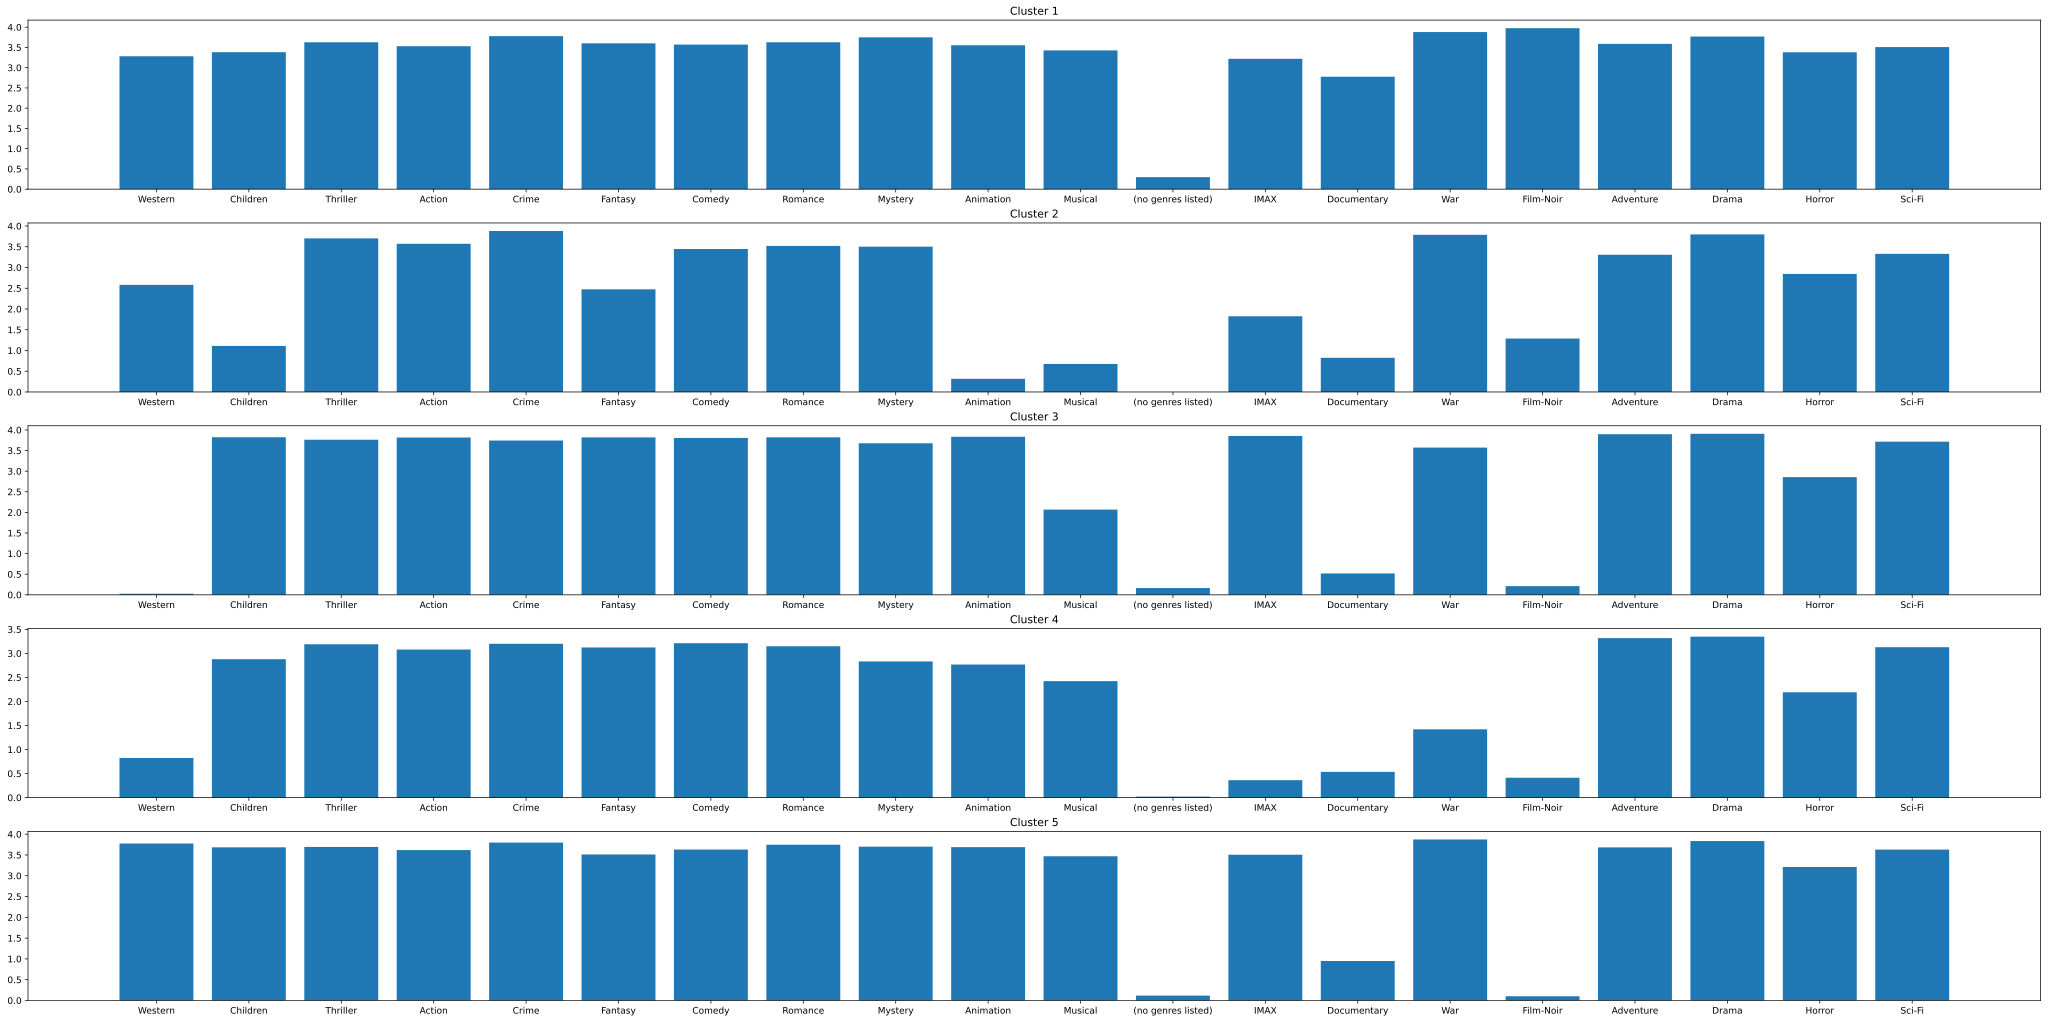

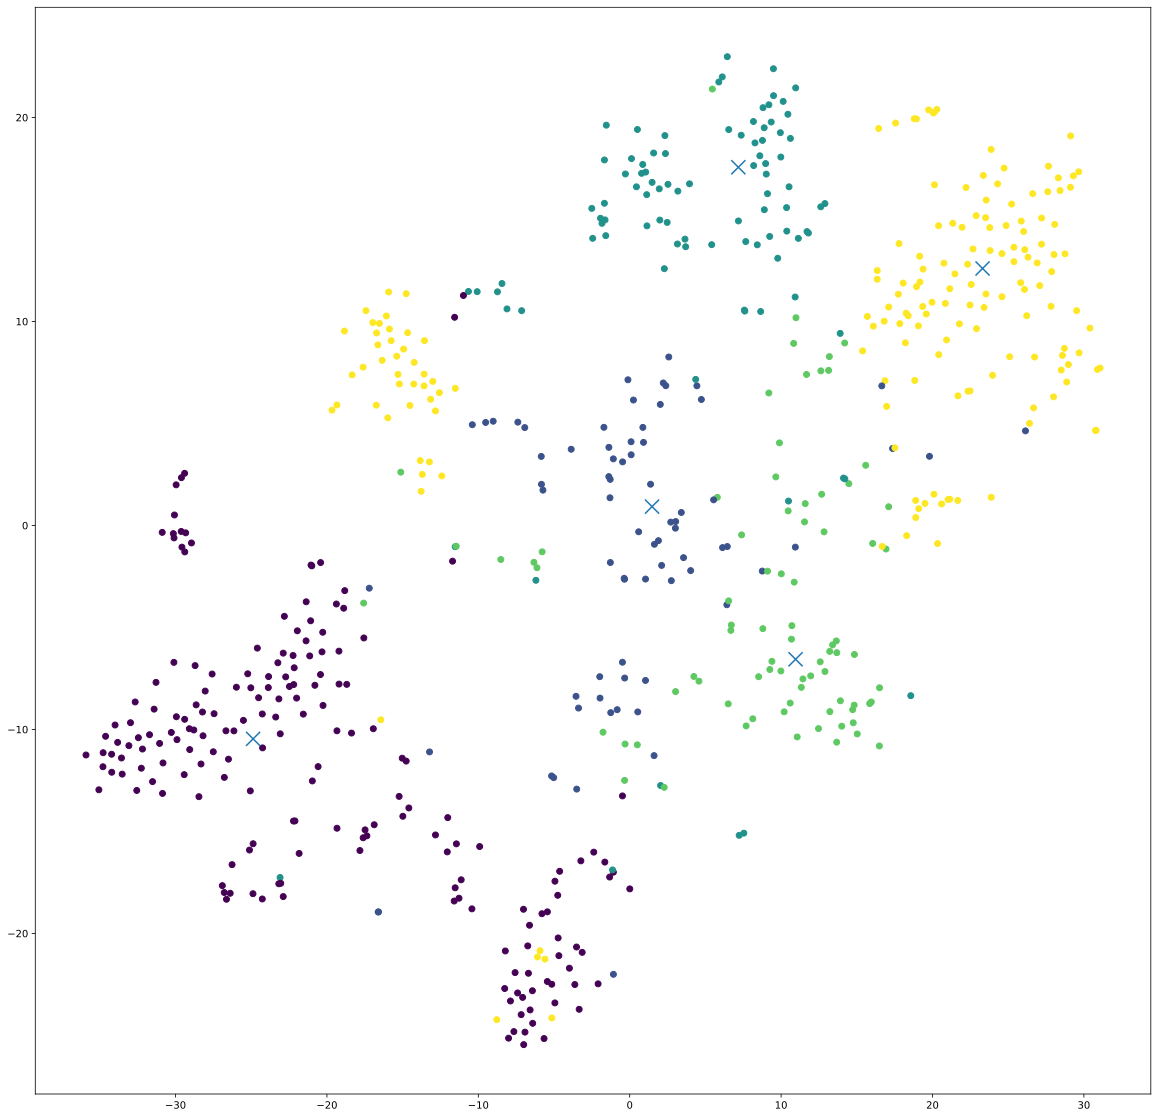

In [ ]:
kmeans = do_kmeans_analysis(5, 4, user_genre_ratings_use)

In [ ]:
user_4_cluster = kmeans.labels_[3]
user_42_cluster = kmeans.labels_[41]
user_314_cluster = kmeans.labels_[313]

print(user_4_cluster)
print(user_42_cluster)
print(user_314_cluster)

0
0
4


In [ ]:
## Clusters:
# 4 - in 0
# 42 - in 0
# 314 - in 4
#labels = gmm.predict(embeddings)



---



## Find the most popular movies within clusters that contain the target users, that the target users have not already seen.

Q. For Q1 again, do we have any train/test splits? If not, how can we confirm that our approach works?

A. There are no train/test splits. One possible way to test your model is to pick a few users and remove (at random) some of the movies that they've watched. Then try to recommend movies to them. If the system is recommending movies that you removed but they've actually enjoyed, it's doing something right. Note that if you do this, I'd suggest that for your test subjects make sure you pick users who've watched lots of moves, and only remove a small number of films. This will help ensure that your changes to their viewing history don't change the cluster to which they are assigned.


---

Q. For Q1, how can tell if my recommendations make sense?

A. One way would be to create some test subjects. Pick a few subjects at random, remove a bunch of the movies that they've seen, and then see if you're approach can recommend movies that they've enjoyed. Note that if you do this, I'd suggest that for your test subjects make sure you pick users who've watched lots of moves, and only remove a small number of films. This will help ensure that your changes to their viewing history don't change the cluster to which they are assigned.

In [ ]:
print(kmeans.labels_)

[0 1 3 0 4 4 0 4 0 2 1 3 1 4 4 0 0 0 0 0 0 0 0 2 2 1 0 0 0 2 2 4 0 4 4 1 4
 4 0 4 0 0 4 3 4 4 1 2 2 0 0 4 1 4 3 2 0 4 0 2 1 0 0 0 1 0 4 0 1 4 3 1 4 0
 4 1 2 2 0 2 3 4 2 0 3 4 3 1 4 3 0 2 4 4 0 0 2 2 4 4 2 4 0 0 0 2 4 4 0 1 4
 4 0 3 0 4 4 1 0 3 4 0 4 2 0 4 1 1 0 4 0 0 4 4 0 4 0 2 3 0 4 4 2 4 4 2 3 2
 1 3 3 0 3 2 4 0 3 3 2 0 3 4 3 1 4 0 0 0 4 4 4 4 2 4 3 4 0 4 4 3 4 0 1 2 2
 0 0 0 2 0 0 1 2 1 0 2 1 0 0 0 4 0 4 0 4 3 1 1 2 2 2 0 2 3 0 0 3 1 0 4 0 0
 0 2 3 4 0 3 4 3 1 0 0 4 4 3 2 1 0 4 4 4 2 1 3 0 0 2 0 4 2 2 0 0 3 4 3 2 3
 0 1 3 0 2 1 0 4 1 3 3 3 4 4 0 0 2 3 4 0 2 2 4 2 4 1 0 0 0 4 0 2 4 3 3 1 4
 1 0 1 1 4 1 2 4 0 4 0 3 0 4 3 0 0 4 3 3 0 0 2 2 2 0 4 3 0 0 4 0 3 4 0 0 1
 4 1 0 4 1 0 4 4 3 0 4 3 0 4 4 4 3 0 0 4 0 4 0 0 2 4 1 2 0 3 3 3 2 0 1 4 2
 0 0 4 4 2 0 0 4 4 0 4 4 1 3 0 3 0 2 3 4 0 3 0 1 4 3 1 4 2 2 4 2 4 4 0 3 2
 4 4 0 4 0 1 0 0 1 2 0 0 0 1 0 1 0 0 2 1 0 4 2 1 0 1 4 4 4 1 0 2 0 2 3 2 4
 4 4 4 0 1 4 3 0 0 1 4 3 3 4 4 2 1 0 2 0 0 2 3 4 0 4 2 1 3 0 4 4 0 4 4 0 1
 4 0 0 4 4 2 0 0 2 2 2 1 

### Get the List of Movie IDs for Movies the Users Have Not Seen

In [ ]:
## Set variables
movie_IDs = list(range(len(movies)))

user_4_seen = []
user_4_not = movie_IDs

user_42_seen = []
user_42_not = movie_IDs

user_314_seen = []
user_314_not = movie_IDs

i = 0
j = len(ratings)

In [ ]:
## Get movies seen by user 4
while i < j:
  user_ID = int(ratings.iloc[i]['userId'])
  if user_ID == 4:
    # user_4_not = ratings_cluster_4.append(ratings.iloc[[i]], ignore_index=True)
    user_4_seen.append(int(ratings.iloc[i]['movieId']))
  i = i + 1

## Get movies seen by user 42
i = 0
while i < j:
  user_ID = int(ratings.iloc[i]['userId'])
  if user_ID == 42:
    # user_4_not = ratings_cluster_4.append(ratings.iloc[[i]], ignore_index=True)
    user_42_seen.append(int(ratings.iloc[i]['movieId']))
  i = i + 1

## Get movies seen by user 314
i = 0
while i < j:
  user_ID = int(ratings.iloc[i]['userId'])
  if user_ID == 314:
    # user_4_not = ratings_cluster_4.append(ratings.iloc[[i]], ignore_index=True)
    user_314_seen.append(int(ratings.iloc[i]['movieId']))
  i = i + 1

In [ ]:
## Get movies NOT seen by user 4
user_4_not = [x for x in movie_IDs if x not in user_4_seen]
user_4_not.remove(0)

## Get movies NOT seen by user 42
user_42_not = [x for x in movie_IDs if x not in user_42_seen]
user_42_not.remove(0)

## Get movies NOT seen by user 314
user_314_not = [x for x in movie_IDs if x not in user_314_seen]
user_314_not.remove(0)

### Get Movies Seen by Users in Cluster 0 and 4

In [ ]:
## Get list of User IDs in clusters 0 and 4
users_0 = []
users_4 = []
i = 0
while i < len(kmeans.labels_):
  if kmeans.labels_[i] == 0:
      users_0.append(i + 1)
  elif kmeans.labels_[i] == 4:
      users_4.append(i + 1)
  i = i + 1

print(len(users_0))
print(users_0)

print(len(users_4))
print(users_4)

190
[1, 4, 7, 9, 16, 17, 18, 19, 20, 21, 22, 23, 27, 28, 29, 33, 39, 41, 42, 50, 51, 57, 59, 62, 63, 64, 66, 68, 74, 79, 84, 91, 95, 96, 103, 104, 105, 109, 113, 115, 119, 122, 125, 129, 131, 132, 135, 137, 140, 152, 156, 160, 166, 167, 168, 177, 182, 186, 187, 188, 190, 191, 195, 198, 199, 200, 202, 204, 212, 215, 216, 219, 221, 222, 223, 227, 232, 233, 239, 246, 247, 249, 253, 254, 260, 263, 266, 274, 275, 279, 286, 287, 288, 290, 298, 305, 307, 309, 312, 313, 317, 318, 322, 325, 326, 328, 331, 332, 336, 339, 343, 346, 351, 352, 354, 356, 357, 362, 367, 371, 372, 376, 377, 380, 385, 387, 391, 393, 405, 410, 412, 414, 415, 418, 419, 420, 422, 424, 425, 428, 432, 438, 440, 448, 452, 453, 462, 464, 465, 469, 474, 477, 480, 483, 484, 488, 489, 495, 509, 510, 514, 520, 522, 525, 527, 528, 534, 540, 551, 552, 555, 560, 561, 562, 567, 573, 580, 585, 587, 590, 593, 596, 597, 599, 600, 602, 603, 606, 608, 610]
172
[5, 6, 8, 14, 15, 32, 34, 35, 37, 38, 40, 43, 45, 46, 52, 54, 58, 67, 70, 73, 7

### Get Ratings for Movies for Clusters 0 and 4

In [ ]:
## Set variables
ratings_cluster_0_user4 = pd.DataFrame(columns=['userId', 'movieId', 'rating', 'timestamp'])

i = 0
j = len(ratings)

## Get movie ratings for cluster 0, user 4
while i < j:
  user_ID = int(ratings.iloc[i]['userId'])
  movie_ID = int(ratings.iloc[i]['movieId'])
  for id in users_0:
    if user_ID == id and movie_ID in user_4_not:
      ratings_cluster_0_user4 = ratings_cluster_0_user4.append(ratings.iloc[[i]], ignore_index=True)
  i = i + 1

ratings_cluster_0_user4

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,50,5.0,964982931
4,1,70,3.0,964982400
...,...,...,...,...
45142,610,8950,4.5,1493849533
45143,610,8957,3.0,1493847395
45144,610,8961,5.0,1493844829
45145,610,8983,3.5,1493845284


In [ ]:
## Set variables
ratings_cluster_0_user42 = pd.DataFrame(columns=['userId', 'movieId', 'rating', 'timestamp'])

i = 0
j = len(ratings)

## Get movie ratings for cluster 0, user 42
while i < j:
  user_ID = int(ratings.iloc[i]['userId'])
  movie_ID = int(ratings.iloc[i]['movieId'])
  for id in users_0:
    if user_ID == id and movie_ID in user_42_not:
      ratings_cluster_0_user42 = ratings_cluster_0_user42.append(ratings.iloc[[i]], ignore_index=True)
  i = i + 1

ratings_cluster_0_user42

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,6,4.0,964982224
2,1,70,3.0,964982400
3,1,101,5.0,964980868
4,1,151,5.0,964984041
...,...,...,...,...
39148,610,8950,4.5,1493849533
39149,610,8957,3.0,1493847395
39150,610,8961,5.0,1493844829
39151,610,8983,3.5,1493845284


In [ ]:
## Set variables
ratings_cluster_4_user314 = pd.DataFrame(columns=['userId', 'movieId', 'rating', 'timestamp'])

i = 0
j = len(ratings)

## Get movie ratings for cluster 4, user 314
while i < j:
  user_ID = int(ratings.iloc[i]['userId'])
  movie_ID = int(ratings.iloc[i]['movieId'])
  for id in users_4:
     if user_ID == id and movie_ID in user_314_not:
      ratings_cluster_4_user314 = ratings_cluster_4_user314.append(ratings.iloc[[i]], ignore_index=True)
  i = i + 1

ratings_cluster_4_user314

,userId,movieId,rating,timestamp
0,5,34,4.0,847434881
1,5,36,4.0,847435292
2,5,58,5.0,847435238
3,5,232,4.0,847435292
4,5,247,5.0,847435337
...,...,...,...,...
9869,609,892,3.0,847221080
9870,609,1056,3.0,847221080
9871,609,1059,3.0,847221054
9872,609,1150,4.0,847221054


### Final Recommendations for Users

In [ ]:
## User 4
average_rating_4 = get_average_rating_per_film(ratings_cluster_0_user4)
print(average_rating_4.shape)
average_rating_4.sort_values(by='rating', ascending=False)

(4963, 1)


,rating
movieId,
4142,5.0
1631,5.0
495,5.0
5416,5.0
3678,5.0
...,...
6371,0.5
1325,0.5
1328,0.5


In [ ]:
## User 42
average_rating_42 = get_average_rating_per_film(ratings_cluster_0_user42)
print(average_rating_42.shape)
average_rating_42.sort_values(by='rating', ascending=False).iloc[:69,:]

(4739, 1)


,rating
movieId,
3851,5.00
5244,5.00
4116,5.00
4135,5.00
389,5.00
...,...
8580,5.00
8804,5.00
6201,5.00


In [ ]:
## User 314
average_rating_314 = get_average_rating_per_film(ratings_cluster_4_user314)
print(average_rating_314.shape)
average_rating_314.sort_values(by='rating', ascending=False).iloc[:139,:]

(2138, 1)


,rating
movieId,
9010,5.0
2924,5.0
1011,5.0
6549,5.0
3020,5.0
...,...
1252,5.0
176,5.0
1300,5.0




---



---



# Problem 2. Multi-Task Learning.
Using this data you are to implement a multi-task deep learning approach
that, given an input image, classifies the traits:

*   Gender
*   Torso Clothing Type
*    Primary Torso Clothing Colour
*     Leg Clothing Type
*    Primary Leg Clothing Colour, and
*    Presence of Luggage.

Pose and the semantic segmentation data may optionally be used when developing your ap-
proach (though remember that semantic segmentation data is only available for the training
set, so cannot be used as a model input). Additional traits (clothing texture, secondary and
tertiary torso and leg colours) should be ignored.

In [ ]:
## Utils

#
# Utility functions for CAB420, Assignment 1C, Q2
# Author: Simon Denman (s.denman@qut.edu.au)
#

import pandas
import cv2
import os
import tensorflow as tf
import numpy
import matplotlib.pyplot as plt     # for plotting

# load a set of masks that represent the semantic regions of a person. This will load the image into a
# (width, height, 8) array if merge_skin is false; or a (width, height, 6) array is merge_skin is true
#   base_path:  path to the images
#   base_name:  common name for the images
#   merge_skin: bool to indicate if we are going to merge the skin regions into a single channel, or
#               leave them as arms, face, legs
#
#   returns:    a (width, height, 9) or (width, height, 7) image. Really it's just all the binary masks
#               stacked up
#
def load_mask(base_path, base_name, merge_skin = False):

    # hard-coding warning, but really dataset structure can be considered a bit of a constant
    components = ['_hair', '_legs', '_luggage', '_shoes', '_torso', '_skin_arms', '_skin_face', '_skin_legs']
    # loop through and load all the components
    images = []
    for c in components:
        images.append(cv2.imread(os.path.join(base_path, base_name + c + '.png'), cv2.IMREAD_GRAYSCALE) / 255.0)

    # this is a bit ugly, but we know that we have skin in the last three channels, so we can just add
    # those together and then cut the last two channels out
    if (merge_skin):
        images[-3] = images[-3] + images[-2] + images[-1]
        images = images[:-2]

    # convert our list to a numpy array, and then transpose it to get the channels in the correct spot
    return numpy.transpose(numpy.array(images), (1, 2, 0))

# adds a background channel to the mask. This channel is 1.0 (i.e on) when all other channels are 0.0 (off), and
# indicates that there's nothing there. This may seem odd, but is needed if we want to use this mask for a
# semantic segmentation output, in which case we'd need a channel to indicate the absence of anything interesting,
# i.e. the backgorund.
#  mask:    mask to add a background channel to
#
#  returns: mask image with a new channel
#
def add_background_channel_to_mask(mask):
    # create the background
    background = 1.0 - mask[:,:,0]
    for i in range(1, mask.shape[2]):
        background = background - mask[:,:,i]

    # stack the background with the original mask. You can put the background first or last
    # (or in the middle - but first or last makes more sense I think), it doesn't really matter
    return numpy.dstack((mask, background))

# load a dataset. This will optionally load masks, and resize images (and masks) and convert images to a new
# colour space
#   csv_path:      path to the csv file that contains all the meta-data, ground truth, etc
#   image_path:    path to the image of the people for whom we need to recognise traits
#   mask_path:     where are the mask images? If there are none, set this to None
#   target_size:   what size images do you want? This will resize and pad, so will preserve the aspect ratio.
#   target_colour: what colour space do you want to convert to? Default is cv2.COLOR_BGR2RGB to go from
#                  opencv's default backwards world to RGB, but you may also want cv2.COLOR_BGR2GRAY
#                  (though, don't you need to recognise colour?), or something more exotic like HSV or LAB.1
#   merge_skin:    bool to indicate if we are going to merge the skin regions into a single channel, or
#                  leave them as arms, face, legs. Only does anything if mark_path is not None
#
#   returns        two dictionaries: x, which contains the images; and y, which contains all the target things
#                  (gender, colours, etc) and potentially the masks
#
def load_set(csv_path, image_path, mask_path = None, target_size = (60, 100), target_colour = cv2.COLOR_BGR2RGB, merge_skin = False):

    # create storage
    # first for likley model inputs
    x = {}
    x['images'] = []

    # now for likely model outputs
    y = {}
    y['gender'] = []
    y['torso_type'] = []
    y['torso_colour'] = []
    y['leg_type'] = []
    y['leg_colour'] = []
    y['luggage'] = []
    if (mask_path is not None):
        y['mask'] = []

    # load the csv file, which contains paths to images and all the ground truth data
    csv = pandas.read_csv(csv_path)
    for i, row in csv.iterrows():
        # there's a bit going on here, working from the inside out:
        #  - load the file
        #  - convert the colour space
        #  - resize with padding (using tensorflow)
        #  - convert back to numpy (because we used tensorflow)
        x['images'].append(tf.image.resize_with_pad(cv2.cvtColor(cv2.imread(os.path.join(image_path, row['filename'])), target_colour) / 255.0, target_size[1], target_size[0]).numpy())

        # pull out the various bits of ground truth we need
        y['gender'].append(row['gender'])
        y['torso_type'].append(row['tortyp'])
        y['torso_colour'].append(row['torcol'])
        y['leg_type'].append(row['legtyp'])
        y['leg_colour'].append(row['legcol'])
        y['luggage'].append(row['luggage'])
        # is there some other piece of data you want to use? maybe the pose? or some other label? if so then just pull it out too!

        # pull out the mask, if we are doing that
        if (mask_path is not None):
            # a bit like the above, we'll
            #  - load the image
            #  - resize and pad the image
            #  - convert back to numpy
            #  - add a background channel
            # The background channel is done last to ensure that the newly added padded regions are included as
            # background (i.e. contain nothing of interest)
            y['mask'].append(add_background_channel_to_mask(tf.image.resize_with_pad(load_mask(mask_path, os.path.splitext(row['filename'])[0], merge_skin), target_size[1], target_size[0]).numpy()))

    x['images'] = numpy.array(x['images'])
    for key in y:
        y[key] = numpy.array(y[key])

    return x, y

# load the data
#   base_path:     the path to the data, within the directory that this points to there should be the Train_Data
#                  and Test_Data directories
#   target_size:   what size images do you want? This will resize and pad, so will preserve the aspect ratio.
#   target_colour: what colour space do you want to convert to? Default is cv2.COLOR_BGR2RGB to go from
#                  opencv's default backwards world to RGB, but you may also want cv2.COLOR_BGR2GRAY
#                  (though, don't you need to recognise colour?), or something more exotic like HSV or LAB.1
#   merge_skin:    bool to indicate if we are going to merge the skin regions into a single channel, or
#                  leave them as arms, face, legs. Only does anything if mark_path is not None
#
#   returns:       loaded training and testing data
#
def load_data(base_path, target_size = (60, 100), target_colour = cv2.COLOR_BGR2RGB, merge_skin = False):

    train_x, train_y = load_set(os.path.join(base_path, 'Train_Data', 'Train.csv'), os.path.join(base_path, 'Train_Data', 'Originals'), os.path.join(base_path, 'Train_Data', 'Binary_Maps'), target_size = target_size, target_colour = target_colour, merge_skin = merge_skin)
    test_x, test_y = load_set(os.path.join(base_path, 'Test_Data', 'Test.csv'), os.path.join(base_path, 'Test_Data', 'Originals'), target_size = target_size, target_colour = target_colour, merge_skin = merge_skin)

    return train_x, train_y, test_x, test_y

# does what it says on the box, makes a mask a bit prettier and a lot more practical for display
#   mask_image: input, N channel mask image
#
#   returns:    mask collapsed to a single channel, channels have been weighted and summed such that each
#               channel should occupy it's own space in the colour map of your choice
#
def make_a_mask_image_ready_for_display(mask_image):
    num_channels = mask_image.shape[2]
    im = mask_image[:,:,0]*(1.0/mask_image.shape[2])
    for i in range(1, num_channels):
        im = im + mask_image[:,:,i]*(i/mask_image.shape[2])
    return im

# Plot some images. Will plot the first 50 samples in a 10x5 grid
#  x: array of images, of shape (samples, width, height, channels)
#
def plot_images(images):
    fig = plt.figure(figsize=[15, 18])
    for i in range(50):
        ax = fig.add_subplot(5, 10, i + 1)
        ax.imshow(images[i,:], cmap=plt.get_cmap('Greys'))
        ax.axis('off')

# Plot some images and their masks. Will plot the first 25 samples in a 10x5 grid,
# alternating between images and masks
#  x: array of images, of shape (samples, width, height, channels)
#  masks: array of masks, of shape (samples, width, height, channels)
#
def plot_images_and_masks(images, masks):
    fig = plt.figure(figsize=[15, 18])
    for i in range(25):
        ax = fig.add_subplot(5, 10, i*2 + 1)
        ax.imshow(images[i,:], cmap=plt.get_cmap('Greys'))
        ax.axis('off')
        ax = fig.add_subplot(5, 10, i*2 + 2)
        ax.imshow(make_a_mask_image_ready_for_display(masks[i,:]), cmap=plt.get_cmap('RdYlBu'))
        ax.axis('off')


In [ ]:
## Load the data
train_x, train_y, test_x, test_y = load_data('/content/drive/My Drive/Assignment 1C/CAB420_Assessment_1C_Data/Q2/Q2')
for key in train_y:
    print(key)

gender
torso_type
torso_colour
leg_type
leg_colour
luggage
mask


In [ ]:
## Set -1 values as a new class
# ML = ['gender', 'torso_type', 'torso_colour', 'leg_type', 'leg_colour', 'luggage']
class_3 = ['gender', 'torso_type', 'leg_type', 'luggage']
class_12 = ['torso_colour', 'leg_colour']

## Test
for x in class_3:
  for i in range(len(test_y[x])):
    if (test_y[x][i] == -1):
      test_y[x][i] = 2

for x in class_12:
  for i in range(len(test_y[x])):
    if (test_y[x][i] == -1):
      test_y[x][i] = 11

## Train
for x in class_3:
  for i in range(len(train_y[x])):
    if (train_y[x][i] == -1):
      train_y[x][i] = 2

for x in class_12:
  for i in range(len(train_y[x])):
    if (train_y[x][i] == -1):
      train_y[x][i] = 11
  # print(x)
  # print(len(a))
  # print(a)
  # print(len(no_negative))
  # print(no_negative)

In [ ]:
train_y

{'gender': array([0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 2, 1, 0,
        1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
        0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 1, 1,



---



## From Datagen Example

### Data Generator

In [ ]:
# Class for the data generator
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'

    # Input arguments are as follows:
    #  x:            our X data array that we'll augment
    #  y_one:        y labels for the first output
    #  y_two:        y labels for the second ouput
    #  y_three:      y labels for the first output
    #  y_four:       y labels for the second ouput
    #  y_five:       y labels for the first output
    #  y_six:        y labels for the second ouput
    #  data_aug:     our data augmentor
    #  batch_size:   the batch size to return from the generator
    #  dim:          size of images
    #  n_channels:   number of image channels
    #  shuffle:      flag to indicate if we should shuffle the data at the end of the epoch
    def __init__(self, x, y_one, y_two, y_three, y_four, y_five, y_six, data_aug,
                 batch_size=32, dim=(100,60), n_channels=3,
                 shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.x = x
        self.y_one = y_one
        self.y_two = y_two
        self.y_three = y_three
        self.y_four = y_four
        self.y_five = y_five
        self.y_six = y_six
        self.data_aug = data_aug
        self.list_IDs = np.arange(0, self.x.shape[0])
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


    # Function to generate data. This will take in a list of sample indicies, and then for each
    # these apply augmentation, and return the augmented data and labels
    #
    # If you wish to check the mechanics out in more detail, you can uncomment the two print lines
    # which will show you the IDs that are being manipulated and help show what's going on - however
    # this will also generate a lot of output text during model training.
    #
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization - creating space for X and y data
#        print(list_IDs_temp)
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        # creating a list of empty arrays to hold our data labels.
        # would initialise this for the number of output labels we have
        y = [np.empty((self.batch_size), dtype=int),
             np.empty((self.batch_size), dtype=int),
             np.empty((self.batch_size), dtype=int),
             np.empty((self.batch_size), dtype=int),
             np.empty((self.batch_size), dtype=int),
             np.empty((self.batch_size), dtype=int)]

        # Generate data, loop through the list of IDs we have and generate data for each in turn
        for i, ID in enumerate(list_IDs_temp):
#            print(ID)
            # apply random transformation based of our datagen instance
            X[i,] = self.data_aug.random_transform(self.x[ID,])
            # copy our y labels across
            y[0][i,] = self.y_one[ID]
            y[1][i,] = self.y_two[ID]
            y[2][i,] = self.y_three[ID]
            y[3][i,] = self.y_four[ID]
            y[4][i,] = self.y_five[ID]
            y[5][i,] = self.y_six[ID]

        return X, y

### Augmentation

In [ ]:
# creating image aug with some really wild and extreme augmentation params
# Ad noted above: these params are not suitable, just used to demo it in practice
data_aug = ImageDataGenerator(
                            # rotate between -45, +45 degrees
                            rotation_range=45,
                            # horiziontal shift by +/- 50% of the image width
                            width_shift_range=0.5,
                            # vertical shift by +/- 50% of the image width
                            height_shift_range=0.5,
                            # range for randomly applying a shearing transform
                            shear_range=0.5,
                            # range for zooming
                            zoom_range=0.5,
                            # allow horizontal flips of data
                            horizontal_flip=True,
                            # what value to place in new pixels, given the nature of our data (clothes on a black backround)
                            # we'll set this to a constant value of 0
                            fill_mode='constant', cval=0)

In [ ]:
# create generator for our dataset

datagen = DataGenerator(train_x['images'], train_y['gender'], train_y['torso_type'], train_y['torso_colour'], train_y['leg_type'], train_y['leg_colour'], train_y['luggage'], data_aug, batch_size=16)

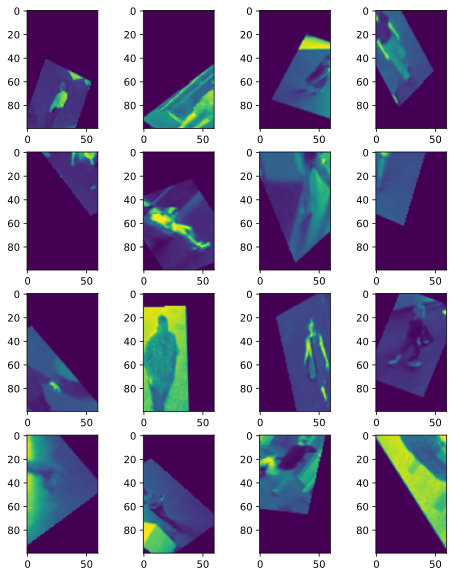

In [ ]:
# lets just test how it works
# will just get a random batch from here (just pick the first one)
x_, y_ = datagen[1]
fig = plt.figure(figsize=[8, 10])
for i in range(0, 16):
    ax = fig.add_subplot(4, 4, i + 1)
    ax.imshow(x_[i, :,:,0])

In [ ]:
## We'll now confirm that we have two y outptus, i.e. two set of layers. In our case this should return the same set of labels twice.
print(y_)

[array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]), array([1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1]), array([ 9,  9,  4,  4, 10,  9,  7,  0,  4,  0,  9,  4,  5,  8,  9,  4]), array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1]), array([ 0,  1,  0,  1,  0, -1,  0,  0,  1,  1,  0,  1,  1,  0,  1,  4]), array([0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0])]




---

## Q2 Working:
Using this data you are to implement a multi-task deep learning approach
that, given an input image, classifies the traits:


*   Gender
*   Torso Clothing Type
*   Primary Torso Clothing Colour
*   Leg Clothing Type
*   Primary Leg Clothing Colour, and
*   Presence of Luggage

## Design DCNN architecture


In [ ]:
## Build model

# function to build a model, takes the number of classes. Can optionally change the output activation.
# See the discussion at bottom of this script for more details about that.
def build_model():
    # our model, input in an image shape
    inputs = keras.Input(shape=(100, 60, 3, ), name='img')

    # run pairs of conv layers, all 3s3 kernels
    x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu')(inputs)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)

    # flatten layer
    x = layers.Flatten()(x)

    # we'll use a couple of dense layers here, mainly so that we can show what another dropout layer looks like
    # in the middle
    # x = layers.Dense(64, activation='relu')(x)
    # x = layers.Dropout(0.5)(x)
    # x = layers.Dense(64, activation='relu')(x)
    # x = layers.Dropout(0.5)(x)
    # x = layers.Dense(64, activation='relu')(x)
    # # the output
    # outputs = layers.Dense(num_classes, activation=output_activation)(x)

    x1 = layers.Dense(64, activation='relu')(x)
    output_1 = layers.Dense(3, name='Gender')(x1)
    x2 = layers.Dense(64, activation='relu')(x)
    output_2 = layers.Dense(3, name='TorsoType')(x2)
    x3 = layers.Dense(64, activation='relu')(x)
    output_3 = layers.Dense(12, name='TorsoColour')(x3)
    x4 = layers.Dense(64, activation='relu')(x)
    output_4 = layers.Dense(3, name='LegType')(x4)
    x5 = layers.Dense(64, activation='relu')(x)
    output_5 = layers.Dense(12, name='LegColour')(x5)
    x6 = layers.Dense(64, activation='relu')(x)
    output_6 = layers.Dense(3, name='Luggage')(x6)

    # build the model, and print a summary
    # multitask_cnn = keras.Model(inputs=inputs, outputs=outputs, name='kmnist_cnn_model')
    multitask_cnn = keras.Model(inputs=inputs, outputs=[output_1, output_2, output_3, output_4, output_5, output_6], name='fmnist_dummy_model')

    return multitask_cnn

multitask_cnn = build_model()
multitask_cnn.summary()

Model: "fmnist_dummy_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 100, 60, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 98, 58, 8)    224         ['img[0][0]']                    
                                                                                                  
 max_pooling2d_30 (MaxPooling2D  (None, 49, 29, 8)   0           ['conv2d_45[0][0]']              
 )                                                                                                
                                                                                 

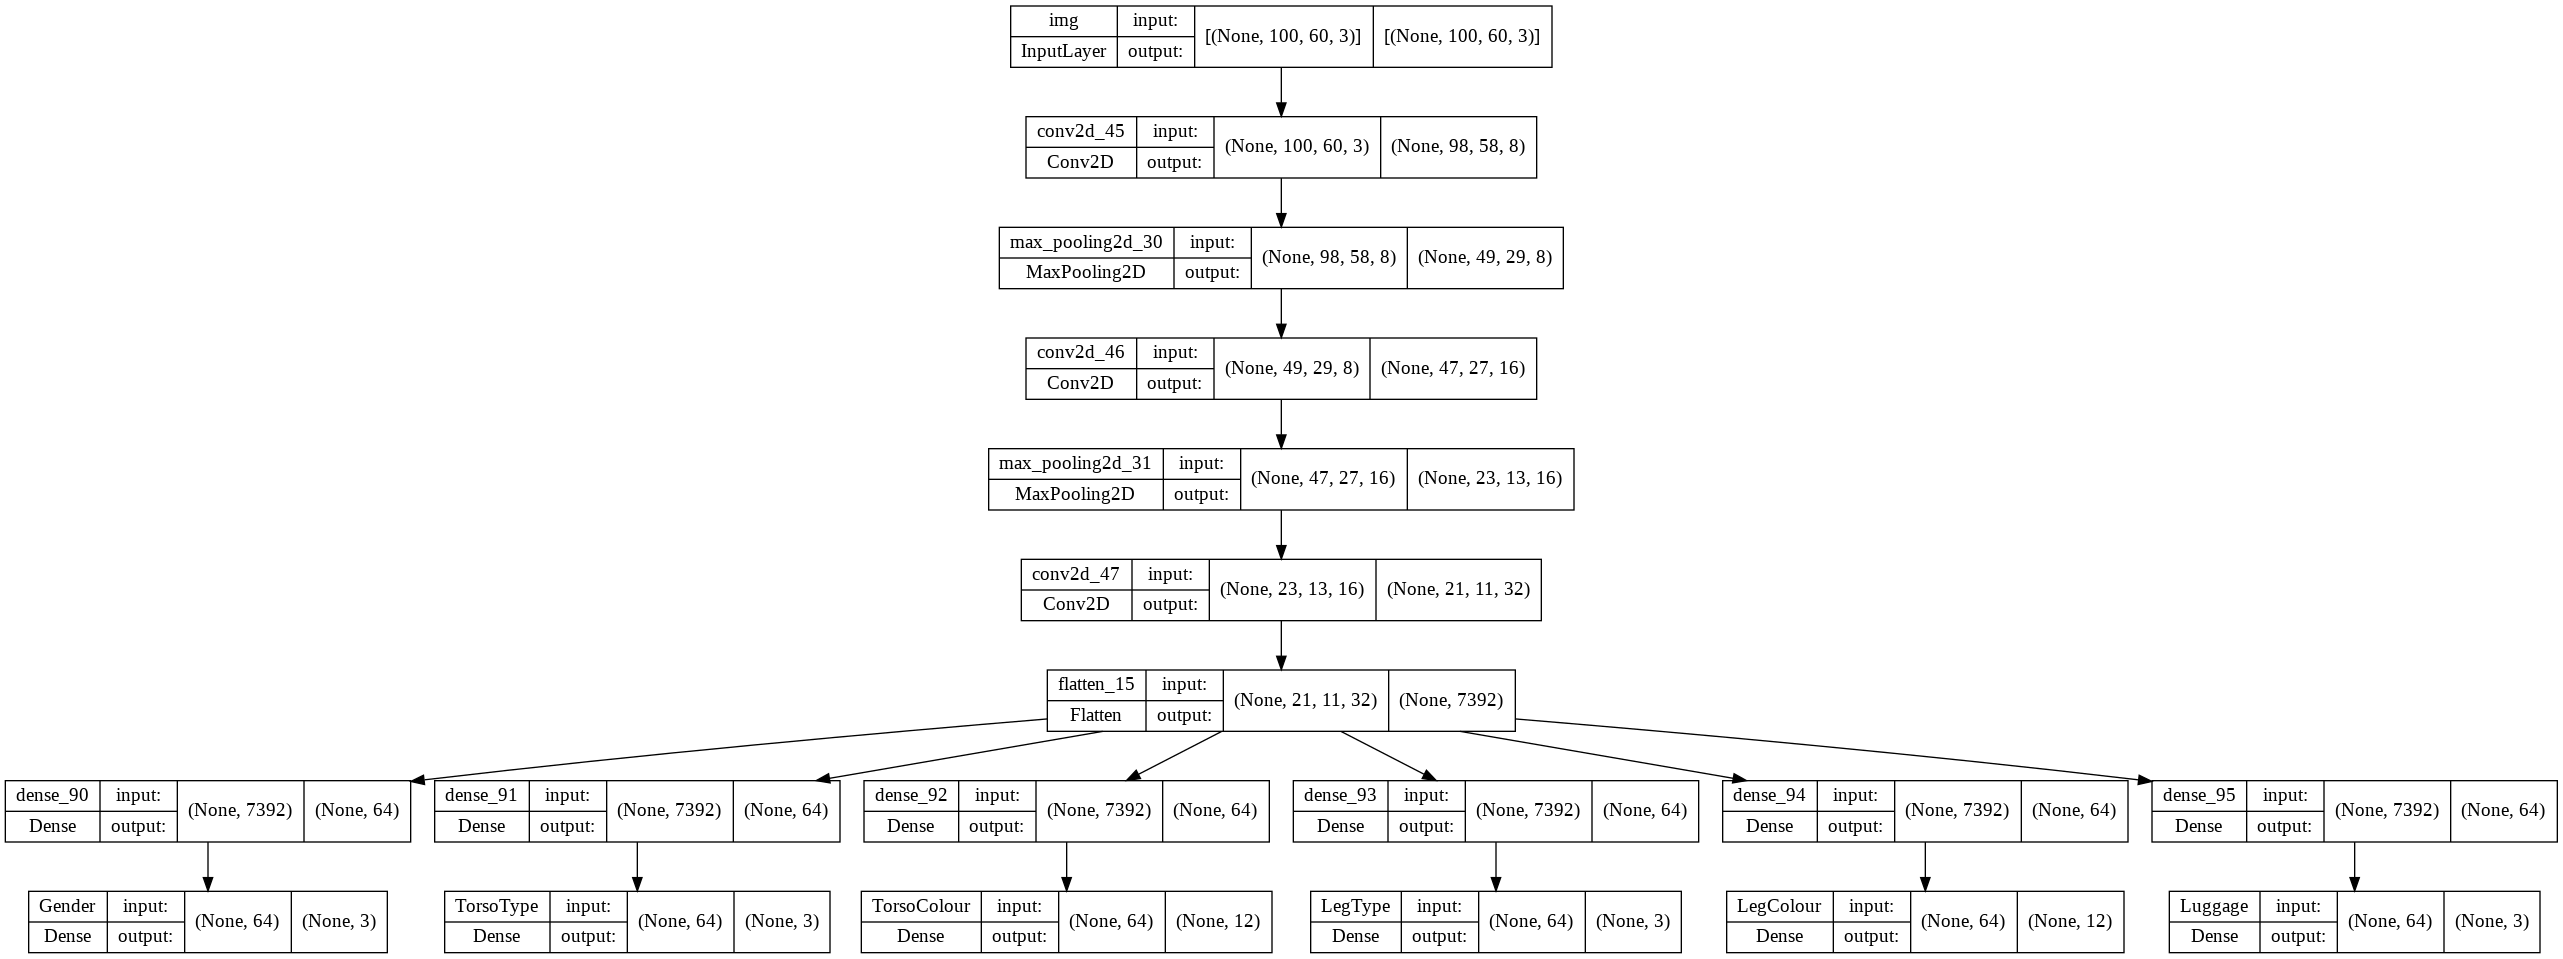

In [ ]:
keras.utils.plot_model(multitask_cnn, show_shapes=True)

## Train the data

In [ ]:
## Data loss
def masked_cce(y_true, y_pred):
    y_true_masked = tf.boolean_mask(y_true, tf.reduce_any(tf.not_equal(y_true, -1), 1))
    y_pred_masked = tf.boolean_mask(y_pred, tf.reduce_any(tf.not_equal(y_true, -1), 1))
    return K.mean(K.sparse_categorical_crossentropy(y_true_masked, y_pred_masked))

In [ ]:
multitask_cnn = build_model() # so that it runs from scratch each time

# model_cnn.compile(loss=[keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                         keras.losses.SparseCategoricalCrossentropy(from_logits=True)],
#               optimizer=keras.optimizers.RMSprop())
loss_type = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt_type = keras.optimizers.RMSprop()
# multitask_cnn.compile(optimizer='adam', loss=[masked_cce, masked_cce, masked_cce, masked_cce, masked_cce, masked_cce]) #, metrics=['accuracy'])
multitask_cnn.compile(optimizer=opt_type, loss=[loss_type, loss_type, loss_type, loss_type, loss_type, loss_type]) #, metrics=['accuracy'])

# model_cnn.fit(datagen,
#           epochs=10,
#           validation_data=(x_test, [y_test, y_test]))

# history = multitask_cnn.fit(test_x['images'], [test_y['gender'], test_y['torso_type'], test_y['torso_colour'], test_y['leg_type'], test_y['leg_colour'], test_y['luggage']],
history = multitask_cnn.fit(datagen,
                        batch_size=64,
                        epochs=10,
                        validation_data=(test_x['images'], [test_y['gender'], test_y['torso_type'], test_y['torso_colour'], test_y['leg_type'], test_y['leg_colour'], test_y['luggage']]))

Epoch 1/10
32/32 [==============================] - 6s 119ms/step - loss: 7.0311 - Gender_loss: 0.7702 - TorsoType_loss: 0.7958 - TorsoColour_loss: 2.2057 - LegType_loss: 0.7556 - LegColour_loss: 1.7619 - Luggage_loss: 0.7419 - val_loss: 7.0987 - val_Gender_loss: 0.8380 - val_TorsoType_loss: 0.7474 - val_TorsoColour_loss: 2.2509 - val_LegType_loss: 0.6992 - val_LegColour_loss: 1.7244 - val_Luggage_loss: 0.8389
Epoch 2/10
32/32 [==============================] - 3s 104ms/step - loss: 6.4645 - Gender_loss: 0.7290 - TorsoType_loss: 0.6959 - TorsoColour_loss: 2.0750 - LegType_loss: 0.6412 - LegColour_loss: 1.6207 - Luggage_loss: 0.7027 - val_loss: 7.1311 - val_Gender_loss: 0.8404 - val_TorsoType_loss: 0.7082 - val_TorsoColour_loss: 2.2057 - val_LegType_loss: 0.7495 - val_LegColour_loss: 1.7504 - val_Luggage_loss: 0.8769
Epoch 3/10
32/32 [==============================] - 3s 106ms/step - loss: 6.4073 - Gender_loss: 0.7213 - TorsoType_loss: 0.6877 - TorsoColour_loss: 2.0695 - LegType_loss: 0



---


## Final Output Visualisation

### Plot loss

In [ ]:
print(history.history)

{'loss': [6.858940124511719, 6.465349197387695, 6.408232688903809, 6.36802864074707, 6.367767810821533, 6.33784818649292, 6.301400184631348, 6.292325496673584, 6.30463981628418, 6.2925238609313965], 'Gender_loss': [0.7674791812896729, 0.7347944974899292, 0.727027416229248, 0.7234300374984741, 0.7250304222106934, 0.7212717533111572, 0.7051653265953064, 0.7193406820297241, 0.7188973426818848, 0.7196298837661743], 'TorsoType_loss': [0.7464948296546936, 0.6954213976860046, 0.7025436162948608, 0.6905550360679626, 0.6862001419067383, 0.6832119226455688, 0.68450528383255, 0.6792171001434326, 0.6756273508071899, 0.6843464374542236], 'TorsoColour_loss': [2.1708061695098877, 2.0812158584594727, 2.061927318572998, 2.056994915008545, 2.0570034980773926, 2.0569143295288086, 2.029306411743164, 2.02854323387146, 2.0255661010742188, 2.0425024032592773], 'LegType_loss': [0.679161548614502, 0.6472030878067017, 0.6293489933013916, 0.6367167234420776, 0.6304967999458313, 0.6228106617927551, 0.626735746860

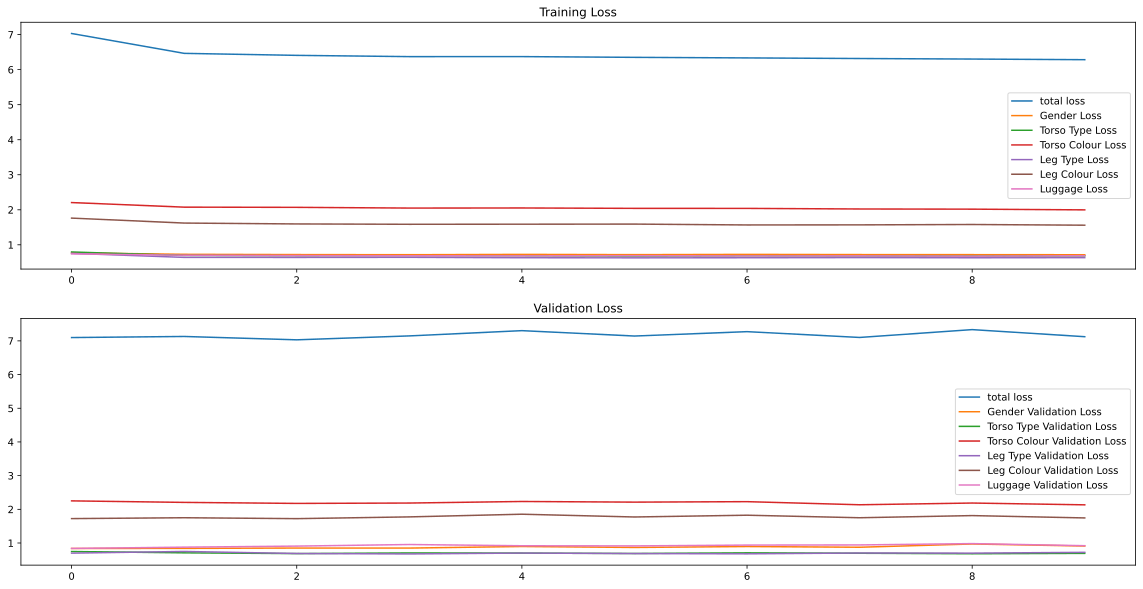

In [ ]:
fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot(2, 1, 1)
ax.plot(history.history['loss'], label='total loss')
ax.plot(history.history['Gender_loss'], label='Gender Loss')
ax.plot(history.history['TorsoType_loss'], label='Torso Type Loss')
ax.plot(history.history['TorsoColour_loss'], label='Torso Colour Loss')
ax.plot(history.history['LegType_loss'], label='Leg Type Loss')
ax.plot(history.history['LegColour_loss'], label='Leg Colour Loss')
ax.plot(history.history['Luggage_loss'], label='Luggage Loss')
ax.set_title('Training Loss')
ax.legend()
ax = fig.add_subplot(2, 1, 2)
ax.plot(history.history['val_loss'], label='total loss')
ax.plot(history.history['val_Gender_loss'], label='Gender Validation Loss')
ax.plot(history.history['val_TorsoType_loss'], label='Torso Type Validation Loss')
ax.plot(history.history['val_TorsoColour_loss'], label='Torso Colour Validation Loss')
ax.plot(history.history['val_LegType_loss'], label='Leg Type Validation Loss')
ax.plot(history.history['val_LegColour_loss'], label='Leg Colour Validation Loss')
ax.plot(history.history['val_Luggage_loss'], label='Luggage Validation Loss')
ax.set_title('Validation Loss')
ax.legend()

### Plot confusion matrix

Gender: -1 (unknown), 0 (male), 1 (female)

 - Pose: -1 (unknown), 0 (front), 1 (back), 2 (45 degrees), 3 (90 degrees)

Torso Clothing Type: -1 (unknown), 0 (long), 1 (short)

Torso Clothing Colour: -1 (unknown), 0 (black), 1 (blue), 2 (brown), 3 (green), 4
(grey), 5 (orange), 6 (pink), 7 (purple), 8 (red), 9 (white), 10 (yellow)

 - Torso Clothing Texture: -1 (unknown) , 0 (irregular), 1 (plaid), 2 (diagonal plaid), 3
(plain), 4 (spots), 5 (diagonal stripes), 6 (horizontal stripes), 7 (vertical stripes)

Leg Clothing Type: -1 (unknown), 0 (long), 1 (short)

Leg Clothing Colour: -1 (unknown), 0 (black), 1 (brown), 2 (blue), 3 (green), 4 (grey),
5 (orange), 6 (pink), 7 (purple), 8 (red), 9 (white), 10 (yellow)

 - Leg Clothing Texture: -1 (unknown) , 0 (irregular), 1 (plaid), 2 (diagonal plaid), 3
(plain), 4 (spots), 5 (diagonal stripes), 6 (horizontal stripes), 7 (vertical stripes)

Luggage: -1 (unknown), 0 (yes), 1 (no)

In [ ]:
print(multitask_cnn.output_shape)

[(None, 3), (None, 3), (None, 12), (None, 3), (None, 12), (None, 3)]


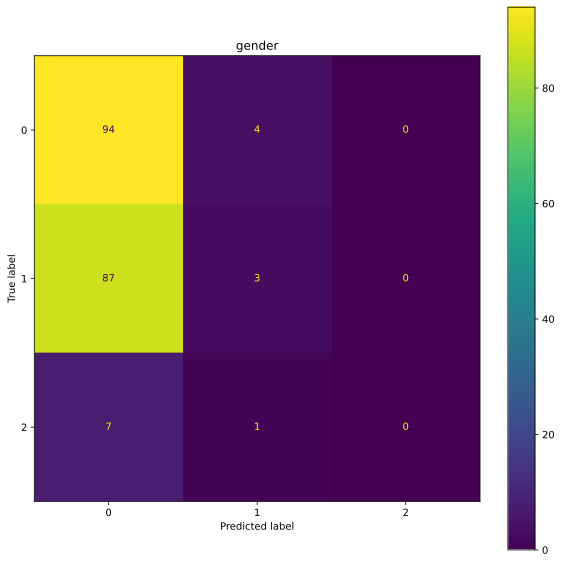

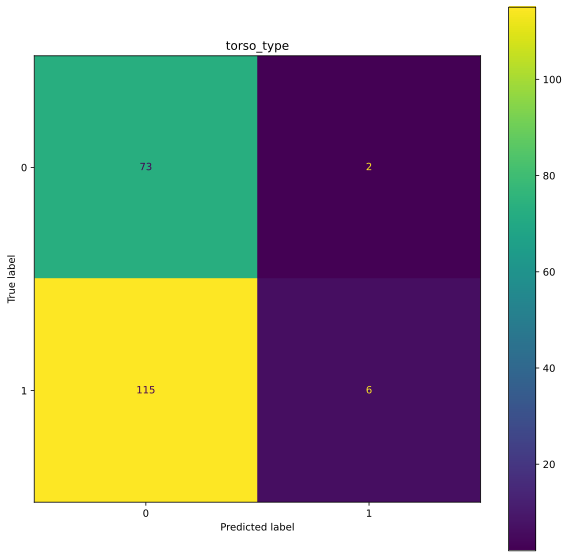

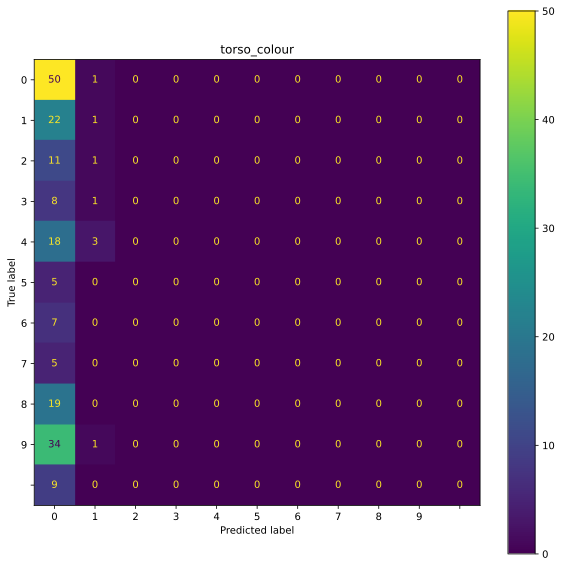

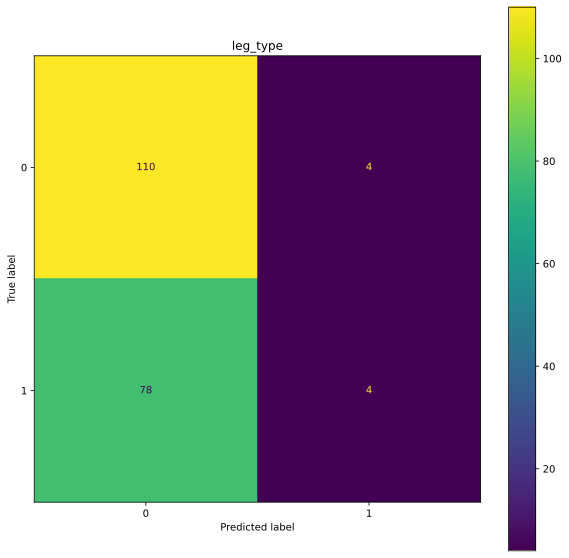

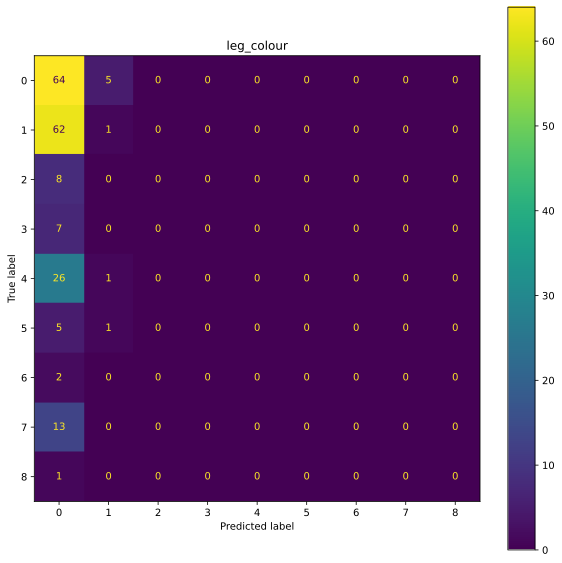

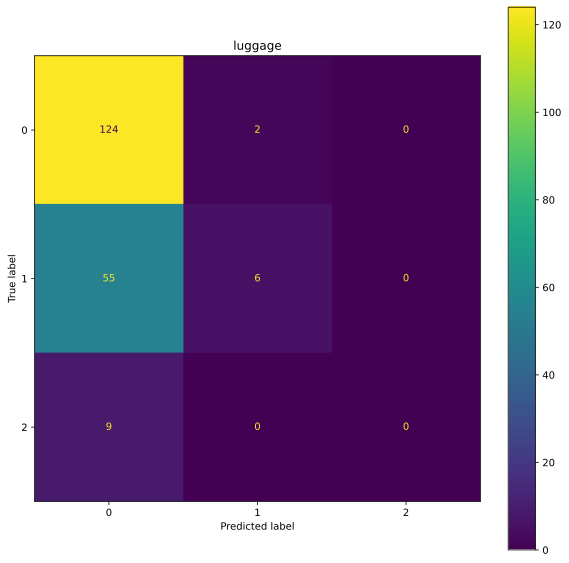

In [ ]:
def eval_models(model, x_test, y_test, title):

    # y_test = tf.argmax(y_test['gender'],axis=1)
    predictions_label = model.predict(x_test)
    # print(predictions_label)
    # indexes = tf.argmax(predictions_label, axis=1)
    indexes = tf.argmax(predictions_label[0],axis=1)
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(y_test, indexes)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)
    c.ax_.set_title(title);

# eval_models(model_cnn, x_test, y_test_rot, y_test, history)
# [test_y['gender'], test_y['torso_type'], test_y['torso_colour'], test_y['leg_type'], test_y['leg_colour'], test_y['luggage']]
ML = ['gender', 'torso_type', 'torso_colour', 'leg_type', 'leg_colour', 'luggage']
for T in ML:
  eval_models(multitask_cnn, test_x['images'], test_y[T], T)



---



---



# Export as PDF

In [ ]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('n10477659 Final Assignment_1C.ipynb')

--2022-06-05 11:21:58--  https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1864 (1.8K) [text/plain]
Saving to: ‘colab_pdf.py’

colab_pdf.py        100%[===================>]   1.82K  --.-KB/s    in 0s      

2022-06-05 11:21:58 (32.2 MB/s) - ‘colab_pdf.py’ saved [1864/1864]





Extracting templates from packages: 100%
[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/n10477659 Final Assignment_1C.ipynb to pdf
[NbConvertApp] Support files will be in n10477659 Final Assignment_1C_files/
[NbConvertApp] Making directory ./n10477659 Final Assignment_1C_files
[NbConvertApp] Making directory ./n10477659 Final Assignment_1C_files
[NbConvertApp] Making directory ./n10477659 Fi

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'